## Basic Setting

In [ ]:
import os
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
import cv2
from collections import Counter
from fastai.vision.all import *

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
train_path = '/content/drive/MyDrive/archive (3)/train'
test_path = '/content/drive/MyDrive/archive (3)/test'

## Four Coffee Bean Roast Levels

In [ ]:
train_categories = os.listdir(train_path)
test_categories = os.listdir(test_path)
print(train_categories)
print(test_categories)

['Dark', 'Medium', 'Green', 'Light']
['Light', 'Green', 'Medium', 'Dark']


### Numbers of images in each class

In [ ]:
nums_train = {}
for train_categories in train_categories:
    nums_train[train_categories] = len(os.listdir(train_path + '/' + train_categories))
img_each_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["Total no. of images"])
print('Distribution of Coffee train data :')
img_each_class_train

Distribution of Coffee train data :


,Total no. of images
Dark,300
Medium,300
Green,300
Light,300


In [ ]:
nums_test = {}
for test_categories in test_categories:
    nums_test[test_categories] = len(os.listdir(test_path + '/' + test_categories))
img_each_class_test = pd.DataFrame(nums_test.values(), index=nums_test.keys(), columns=["Total no. of images"])
print('Distribution of Coffee test data :')
img_each_class_test

Distribution of Coffee test data :


,Total no. of images
Light,100
Green,100
Medium,100
Dark,100


In [ ]:
# show number of images in train data
number_train = 0
for value in nums_train.values():
    number_train += value
print("The number of images for training : ",number_train)

The number of images for training :  1200


In [ ]:
number_test = 0
for value in nums_test.values():
    number_test += value
print("The number of images for test : ",number_test)

The number of images for test :  400


## example_images

In [ ]:
example_images = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(256, method='squish'),  # Change the size to 256x256
    batch_tfms=aug_transforms(size=128, min_scale=0.75))
example_images.show_batch(max_n=4)

### Check Input Shape

In [ ]:
# Define the directory where your dataset is stored
dataset_dir = train_path

# Initialize an empty list to store input shapes
input_shapes = []

# Iterate through the files in the dataset directory
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(('.png')):  # You can specify the image file extensions
            file_path = os.path.join(root, file)

            # Load and read the image using OpenCV
            image = cv2.imread(file_path)

            # Get the input shape and add it to the list
            input_shapes.append(image.shape)

# Calculate the mean input shape
median_shape = np.median(input_shapes, axis=0)

# Print the mean input shape
print("Input Shape (H x W x C):", median_shape)

Input Shape (H x W x C): [224. 224.   3.]


In [ ]:
image_shape = (224, 224, 3)

## Build CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

model = Sequential()

# Convolutional and MaxPooling layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 26, 26, 128)      

## Data processing

In [ ]:
image_generator = ImageDataGenerator(rotation_range = 20, width_shift_range = 0.1, height_shift_range = 0.1,
                               shear_range = 0.1, zoom_range = 0.1, horizontal_flip = True,
                               fill_mode = 'nearest')

In [ ]:
batch_size = 32

train_image_gen = image_generator.flow_from_directory(train_path, target_size = image_shape[:2],
                                                color_mode = 'rgb', batch_size = batch_size,
                                                class_mode = 'categorical')

# Make sure to make Shuffle = False
test_image_gen = image_generator.flow_from_directory(test_path, target_size = image_shape[:2],
                                                color_mode = 'rgb', batch_size = batch_size,
                                                class_mode = 'categorical', shuffle = False)

train_image_gen.class_indices

results = model.fit(train_image_gen, epochs = 30, validation_data = test_image_gen)

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Epoch 1/30
38/38 [==============================] - 22s 503ms/step - loss: 20.3797 - accuracy: 0.5067 - val_loss: 0.4026 - val_accuracy: 0.9025
Epoch 2/30
38/38 [==============================] - 19s 499ms/step - loss: 0.3638 - accuracy: 0.8617 - val_loss: 0.2041 - val_accuracy: 0.9325
Epoch 3/30
38/38 [==============================] - 19s 498ms/step - loss: 0.2822 - accuracy: 0.8958 - val_loss: 0.2182 - val_accuracy: 0.9050
Epoch 4/30
38/38 [==============================] - 19s 499ms/step - loss: 0.1669 - accuracy: 0.9417 - val_loss: 0.1255 - val_accuracy: 0.9600
Epoch 5/30
38/38 [==============================] - 19s 497ms/step - loss: 0.2181 - accuracy: 0.9225 - val_loss: 0.1668 - val_accuracy: 0.9450
Epoch 6/30
38/38 [==============================] - 19s 499ms/step - loss: 0.1567 - accuracy: 0.9500 - val_loss: 0.0894 - val_accuracy: 0.9700
Epoch 7/30
38/38 [==============================] - 19s 49

## Evaluation

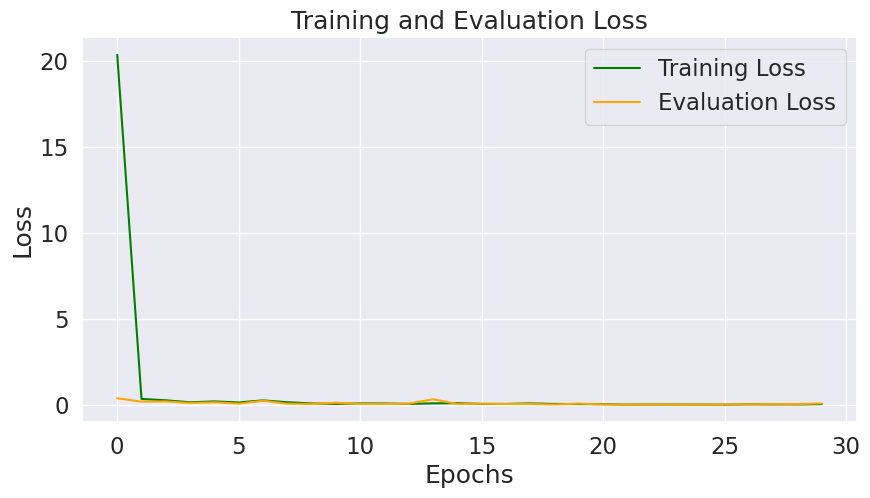

In [ ]:
losses = pd.DataFrame(model.history.history)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the training loss and validation loss
ax.plot(losses['loss'], label='Training Loss', color='green')
ax.plot(losses['val_loss'], label='Evaluation Loss', color='orange')

# Set plot labels and a legend
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Evaluation Loss')
ax.legend()

# Show the plot
plt.show()

In [ ]:
score = model.evaluate(test_image_gen, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 5s 359ms/step - loss: 0.0873 - accuracy: 0.9775
Test loss: 0.08732648938894272
Test accuracy: 0.9775000214576721


In [ ]:
score_train = model.evaluate(train_image_gen, verbose=1)
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])

38/38 [==============================] - 14s 373ms/step - loss: 0.1133 - accuracy: 0.9717
Train loss: 0.11329688876867294
Train accuracy: 0.971666693687439


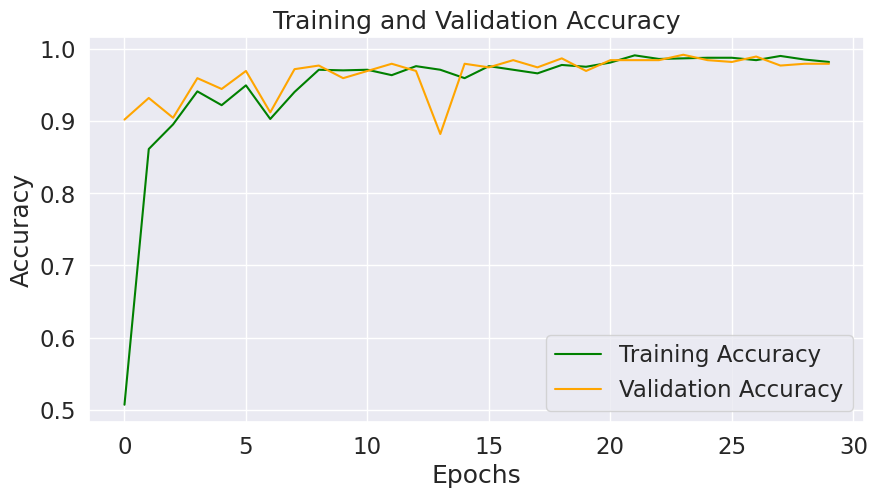

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the training accuracy and validation accuracy
ax.plot(losses['accuracy'], label='Training Accuracy', color='green')
ax.plot(losses['val_accuracy'], label='Validation Accuracy', color='orange')

# Set plot labels and a legend
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy')
ax.legend()

# Show the plot with legend
plt.legend()
plt.show()

In [ ]:
pred = model.predict(test_image_gen) # gives probabilites
predictions = np.argmax(pred, axis = -1)

13/13 [==============================] - 5s 360ms/step


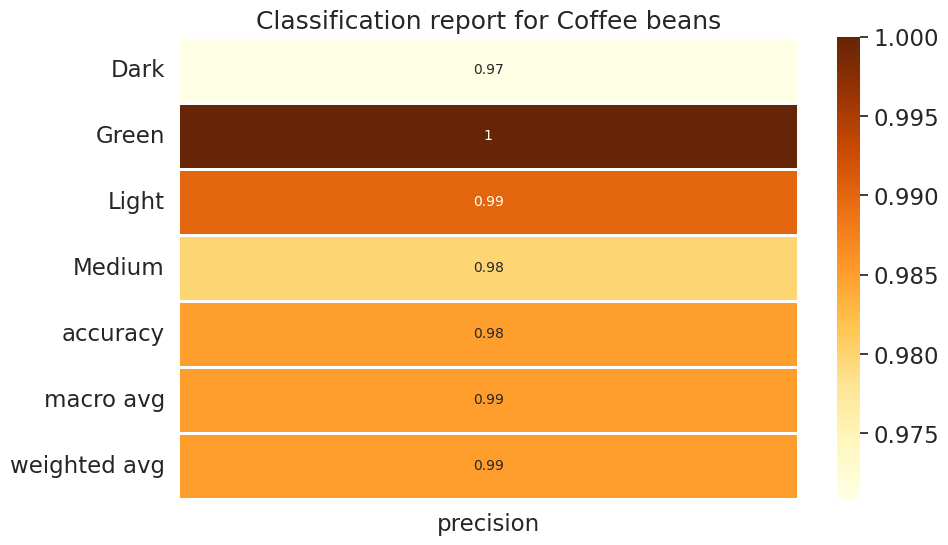

In [ ]:
report = classification_report(test_image_gen.classes, predictions, target_names=list(train_image_gen.class_indices), output_dict=True, zero_division=0)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Extract the relevant data for plotting and exclude macro, weighted avg, and support
report_data = pd.DataFrame(report).iloc[:-3, :].T

# Customize the heatmap using Seaborn with a brown color map
sns.set(font_scale=1.5)  # Adjust font size for better readability
cmap = sns.color_palette("YlOrBr", as_cmap=True)  # Use a YlOrBr color palette
heatmap = sns.heatmap(report_data, annot=True, linewidths=2, annot_kws={'size': 10}, cmap=cmap)
heatmap.set_title("Classification report for Coffee beans")

# Show the plot
plt.show()

## Prediction

In [ ]:
def load_and_preprocess_image(filename, img_shape = 224):
  img = tensorflow.io.read_file(filename) #read image
  img = tensorflow.image.decode_image(img) # decode the image to a tensor
  img = tensorflow.image.resize(img, size = [img_shape, img_shape]) # resize the image
  img = img/255. # rescale the image
  return img

In [ ]:
def visualize_prediction(model, image_path, class_names):
    """
    Imports an image located at the specified path, makes a prediction with a trained model,
    and plots the image with the predicted class as the title.
    """
    # Load and preprocess the target image
    img = load_and_preprocess_image(image_path)

    # Make a prediction
    predictions = model.predict(tensorflow.expand_dims(img, axis=0))

    # Determine the predicted class
    if len(predictions[0]) > 1:  # Check for multi-class
        predicted_class = class_names[np.argmax(predictions)]  # Take the class with the highest probability
    else:
        predicted_class = class_names[int(tensorflow.round(predictions)[0][0])]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis(False)

In [ ]:
class_names = ['Dark','Green','Light','Medium']

1/1 [==============================] - 0s 166ms/step


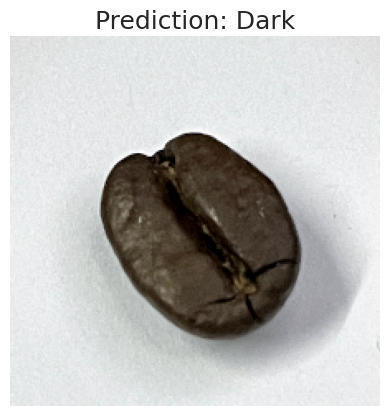

In [ ]:
visualize_prediction(model, "/content/drive/MyDrive/archive (3)/test/Dark/dark (10).png", class_names)

1/1 [==============================] - 0s 19ms/step


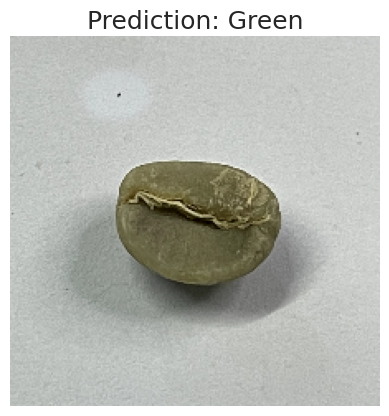

In [ ]:
visualize_prediction(model, "/content/drive/MyDrive/archive (3)/test/Green/green (10).png", class_names)